# Logistic Regression Lab (Jupyter Notebook)

**Course:** BINF 4211 - Applied Data Mining for Bioinformatics (Senior Undergraduate)

**Topic:** Logistic Regression — probability, regularization, and evaluation

## Lab Goals
By the end of this lab, you will be able to:
- Train logistic regression models and obtain **probability predictions**
- Interpret coefficients via **odds ratios** (with proper scaling considerations)
- Compare **L2 vs L1** regularization
- Evaluate models using **confusion matrix**, **ROC/AUC**, and **Precision–Recall**
- Explore how **decision thresholds** change precision/recall tradeoffs
- Handle **class imbalance** and compare ROC vs PR curves

> **Note:** This lab uses only `matplotlib` for plotting (no seaborn).


## 0. Setup

Run the cell below to import packages used in this lab.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer, make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
    classification_report
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1. Dataset A: Breast Cancer (Real Dataset)

We’ll start with a well-known binary classification dataset from scikit-learn.
- **Target:** malignant vs benign (we’ll verify encoding)
- **Features:** numeric measurements

### Task 1
- Load the dataset
- Inspect shapes and class balance


In [2]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

print("X shape:", X.shape)
print("y shape:", y.shape)
print("\nClass counts:")
print(y.value_counts())
print("\nClass proportions:")
print(y.value_counts(normalize=True))

print("\nTarget names:", data.target_names)


X shape: (569, 30)
y shape: (569,)

Class counts:
target
1    357
0    212
Name: count, dtype: int64

Class proportions:
target
1    0.627417
0    0.372583
Name: proportion, dtype: float64

Target names: ['malignant' 'benign']


## 2. Train/Test Split

We’ll use a stratified split to preserve class balance.

### Task 2
- Split into train/test
- Confirm the class balance in each split


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)

def show_balance(y_vec, name):
    vc = y_vec.value_counts()
    vp = y_vec.value_counts(normalize=True)
    print(f"{name} counts:\n{vc}\n")
    print(f"{name} proportions:\n{vp}\n")

show_balance(y_train, "Train")
show_balance(y_test, "Test")


Train counts:
target
1    267
0    159
Name: count, dtype: int64

Train proportions:
target
1    0.626761
0    0.373239
Name: proportion, dtype: float64

Test counts:
target
1    90
0    53
Name: count, dtype: int64

Test proportions:
target
1    0.629371
0    0.370629
Name: proportion, dtype: float64



## 3. Baseline Logistic Regression (with Scaling)

Logistic regression is sensitive to feature scale, especially when regularization is used.
We’ll fit a pipeline: **StandardScaler → LogisticRegression**.

### Task 3
- Fit a baseline model (L2 regularization)
- Predict probabilities on the test set
- Make predictions at threshold 0.5


In [6]:
baseline = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(penalty="l2", solver="lbfgs", max_iter=2000, random_state=RANDOM_STATE))
])

baseline.fit(X_train, y_train)

probs = baseline.predict_proba(X_test)[:, 1]  # probability of class 1
preds_05 = (probs >= 0.5).astype(int)

print("First 10 probabilities:", np.round(probs[:10], 4))
print("First 10 predicted labels (t=0.5):", preds_05[:10])


First 10 probabilities: [9.690e-01 4.000e-04 5.594e-01 9.389e-01 1.755e-01 0.000e+00 2.800e-03
 8.000e-04 7.000e-04 9.999e-01]
First 10 predicted labels (t=0.5): [1 0 1 1 0 0 0 0 0 1]


/opt/anaconda3/envs/teach_ml/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


## 4. Confusion Matrix and Classification Report

### Task 4
- Compute confusion matrix at threshold 0.5
- Print precision/recall/F1


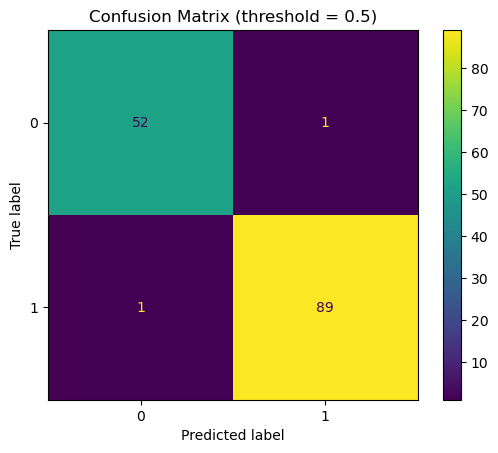

              precision    recall  f1-score   support

           0      0.981     0.981     0.981        53
           1      0.989     0.989     0.989        90

    accuracy                          0.986       143
   macro avg      0.985     0.985     0.985       143
weighted avg      0.986     0.986     0.986       143



In [7]:
cm = confusion_matrix(y_test, preds_05)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix (threshold = 0.5)")
plt.show()

print(classification_report(y_test, preds_05, digits=3))


## 5. ROC Curve and AUC

### Task 5
- Plot ROC curve
- Compute AUC


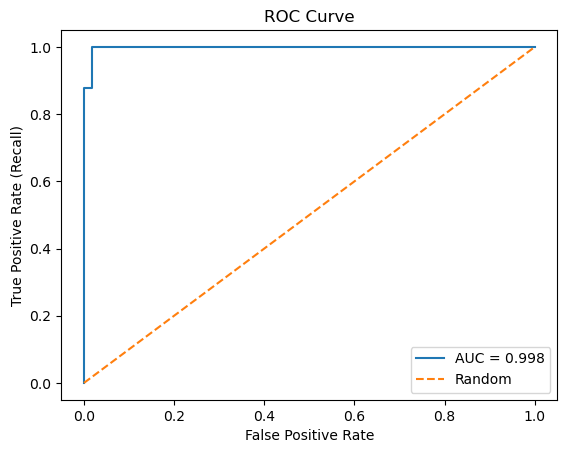

ROC AUC: 0.9976939203354298


In [8]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.show()

print("ROC AUC:", auc)


## 6. Precision–Recall Curve and Average Precision

PR curves are often more informative than ROC curves when the positive class is rare.

### Task 6
- Plot the precision–recall curve
- Compute average precision (area under PR curve)


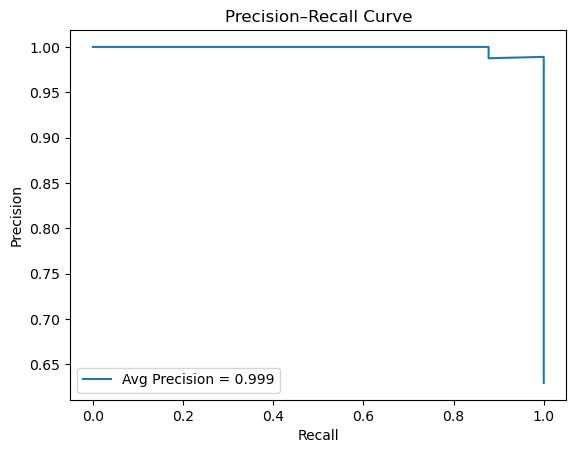

Average precision: 0.9985768851678664


In [9]:
precision, recall, pr_thresholds = precision_recall_curve(y_test, probs)
ap = average_precision_score(y_test, probs)

plt.figure()
plt.plot(recall, precision, label=f"Avg Precision = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.show()

print("Average precision:", ap)


## 7. Threshold Tuning (Tradeoffs)

A threshold of 0.5 is **not** always best.
Let’s see how precision and recall change with the threshold.

### Task 7
- Try thresholds: 0.2, 0.5, 0.8
- Compare confusion matrices and precision/recall


In [10]:
def eval_at_threshold(t):
    preds = (probs >= t).astype(int)
    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    return cm, precision, recall

for t in [0.2, 0.5, 0.8]:
    cm_t, prec_t, rec_t = eval_at_threshold(t)
    print(f"Threshold = {t}")
    print(cm_t)
    print(f"Precision = {prec_t:.3f}, Recall = {rec_t:.3f}")
    print("-"*40)


Threshold = 0.2
[[49  4]
 [ 0 90]]
Precision = 0.957, Recall = 1.000
----------------------------------------
Threshold = 0.5
[[52  1]
 [ 1 89]]
Precision = 0.989, Recall = 0.989
----------------------------------------
Threshold = 0.8
[[52  1]
 [ 6 84]]
Precision = 0.988, Recall = 0.933
----------------------------------------


## 8. Coefficients and Odds Ratios (Careful!)

In a pipeline with scaling, the coefficients correspond to **scaled** features.
Still, we can:
- Inspect coefficient signs and relative magnitude
- Convert coefficients to odds ratios via `exp(beta)`
- Rank features by absolute effect size

### Task 8
- Extract coefficients from the trained model
- Create a table of top coefficients and odds ratios


In [11]:
lr = baseline.named_steps["lr"]
coefs = lr.coef_.ravel()

coef_df = pd.DataFrame({
    "feature": X.columns,
    "beta": coefs,
    "odds_ratio_exp_beta": np.exp(coefs),
    "abs_beta": np.abs(coefs)
}).sort_values("abs_beta", ascending=False)

print("Top 10 features by |beta| (scaled features):")
print(coef_df.head(10).to_string(index=False))


Top 10 features by |beta| (scaled features):
             feature      beta  odds_ratio_exp_beta  abs_beta
       worst texture -1.250149             0.286462  1.250149
        radius error -1.070102             0.342973  1.070102
      worst symmetry -0.957045             0.384026  0.957045
worst concave points -0.941888             0.389891  0.941888
          area error -0.941059             0.390214  0.941059
          worst area -0.925812             0.396210  0.925812
        worst radius -0.917480             0.399525  0.917480
     worst concavity -0.796758             0.450788  0.796758
     worst perimeter -0.721168             0.486184  0.721168
    mean compactness  0.694230             2.002167  0.694230


## 9. Regularization: L2 vs L1

We’ll compare:
- L2 (ridge): shrinks coefficients smoothly
- L1 (lasso): encourages sparsity (many coefficients become 0)

### Task 9
- Fit L2 and L1 models for a range of C values
- Compare test AUC and coefficient sparsity

> In sklearn, **C = 1/λ** (smaller C means stronger regularization).


In [ ]:
Cs = [0.01, 0.1, 1.0, 10.0]
results = []

for C in Cs:
    # L2
    m_l2 = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(penalty="l2", solver="lbfgs", max_iter=4000, C=C, random_state=RANDOM_STATE))
    ])
    m_l2.fit(X_train, y_train)
    p_l2 = m_l2.predict_proba(X_test)[:, 1]
    auc_l2 = roc_auc_score(y_test, p_l2)
    nz_l2 = np.sum(np.abs(m_l2.named_steps["lr"].coef_.ravel()) > 1e-12)

    # L1 (solver supports L1)
    m_l1 = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(penalty="l1", solver="liblinear", max_iter=4000, C=C, random_state=RANDOM_STATE))
    ])
    m_l1.fit(X_train, y_train)
    p_l1 = m_l1.predict_proba(X_test)[:, 1]
    auc_l1 = roc_auc_score(y_test, p_l1)
    nz_l1 = np.sum(np.abs(m_l1.named_steps["lr"].coef_.ravel()) > 1e-12)

    results.append({"C": C, "AUC_L2": auc_l2, "nonzero_L2": int(nz_l2), "AUC_L1": auc_l1, "nonzero_L1": int(nz_l1)})

res_df = pd.DataFrame(results)
print(res_df.to_string(index=False))


## 10. Dataset B: Imbalanced Synthetic Data (ROC vs PR)

Create an imbalanced dataset (e.g., 5% positives) to show why PR curves are often preferred.

### Task 10
- Generate an imbalanced dataset
- Fit logistic regression
- Compare ROC and PR curves


In [ ]:
X2, y2 = make_classification(
    n_samples=3000,
    n_features=20,
    n_informative=5,
    n_redundant=5,
    weights=[0.95, 0.05],  # 5% positives
    flip_y=0.01,
    class_sep=1.0,
    random_state=RANDOM_STATE
)

X2 = pd.DataFrame(X2, columns=[f"f{i}" for i in range(X2.shape[1])])
y2 = pd.Series(y2, name="target")

print("Class proportions:")
print(y2.value_counts(normalize=True))

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.25, stratify=y2, random_state=RANDOM_STATE
)

imb_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(penalty="l2", solver="lbfgs", max_iter=4000, random_state=RANDOM_STATE))
])
imb_model.fit(X2_train, y2_train)
p2 = imb_model.predict_proba(X2_test)[:, 1]

# ROC
fpr2, tpr2, _ = roc_curve(y2_test, p2)
auc2 = roc_auc_score(y2_test, p2)

plt.figure()
plt.plot(fpr2, tpr2, label=f"AUC = {auc2:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (Imbalanced Dataset)")
plt.legend()
plt.show()

# PR
prec2, rec2, _ = precision_recall_curve(y2_test, p2)
ap2 = average_precision_score(y2_test, p2)

plt.figure()
plt.plot(rec2, prec2, label=f"Avg Precision = {ap2:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Imbalanced Dataset)")
plt.legend()
plt.show()

print("ROC AUC:", round(auc2, 3))
print("Average precision:", round(ap2, 3))


## 11. Bonus (Optional): Cross-Validated AUC

### Task 11 (optional)
Estimate model performance using cross-validation on Dataset A.


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(penalty="l2", solver="lbfgs", max_iter=4000, random_state=RANDOM_STATE))
])

scores = cross_val_score(cv_model, X, y, cv=cv, scoring="roc_auc")
print("CV AUC scores:", np.round(scores, 3))
print("Mean AUC:", round(scores.mean(), 3))
print("Std AUC:", round(scores.std(), 3))


## Wrap-Up Questions (Turn In / Discuss)
1. Why does logistic regression naturally produce probabilities but linear regression does not?
2. In the scaled model, what does `exp(beta)` mean?
3. When might you prefer L1 over L2 in bioinformatics?
4. Why can ROC look “good” while PR looks “bad” in imbalanced data?
5. If your goal is to minimize false negatives (missed disease cases), should you raise or lower the threshold?
